### 必要なモジュールのimport

In [2]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score, mean_squared_error
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from collections import Counter

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [3]:
# データの読み込み(02_data_preparation.ipynbで作成したデータ)
train = pd.read_csv('../data/processed/processed20240614_train.csv')
test = pd.read_csv('../data/processed/processed20240614_test.csv')

## targetの分布の確認

C:\Users\harumi.fukushi.bk\AppData\Local\Temp\ipykernel_22072\2946955093.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['target'])


<Axes: xlabel='target', ylabel='Density'>

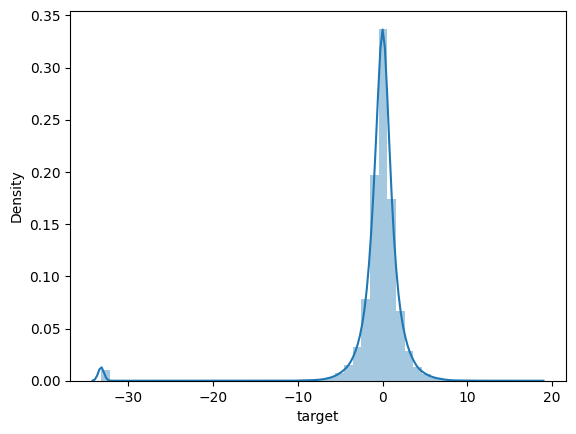

In [4]:
# 目的変数の分布を確認
sns.distplot(train['target'])

<Axes: xlabel='target'>

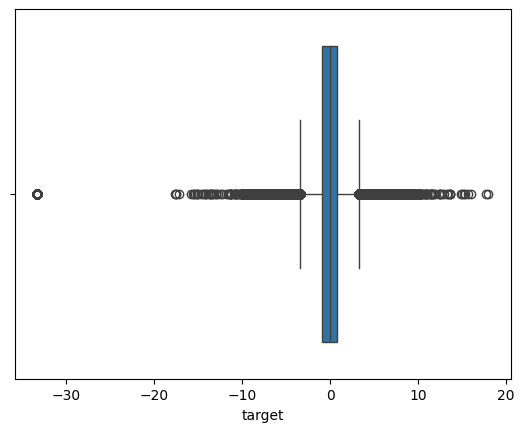

In [5]:
# 箱ひげ図
sns.boxplot(x='target', data=train)

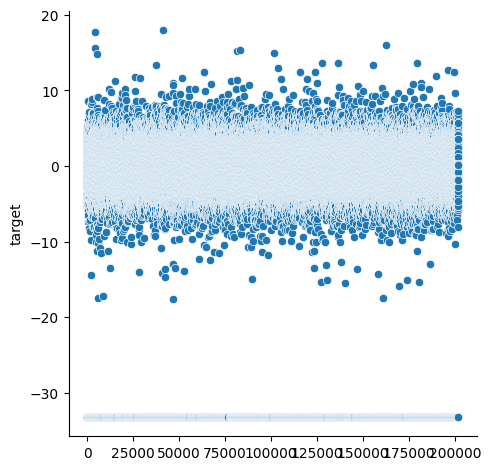

In [6]:
sns.relplot(data=train['target'])

ここまでグラフを見てみると特に-30未満の数字の部分が特に外れ値であると考えられます。   
今回のコンペの評価指標がRMSEとなっていることもあり、こうした極端な外れ値に対してもきちんと予測できないと精度は悪化してしまうため外れ値のフラグを立ててそれを特徴量ととして実装していきましょう。

In [7]:
# 最小値を算出
train['target'].min()

-33.21928095

In [8]:
# ロイヤリティの値が最小値であるデータの量をカウント
len(train[train['target'] == -33.21928095])

2207

In [9]:
# 最大値を算出
train['target'].max()

17.9650684

In [10]:
# ロイヤリティの値が最大値であるデータの量をカウント
len(train[train['target'] == 17.9650684])

1

In [11]:
# カウント範囲を設定
range_min = -15
range_max = int(train['target'].min()) - 1  # -10より小さい最小値を整数に変換して設定
ranges = list(range(range_max, range_min, 1))  # 1刻みで範囲を生成

# カウントを行う
counts = [len(train[train['target'] < r]) for r in ranges]

# データフレームにまとめる
count_df = pd.DataFrame({'範囲': ranges, 'データの個数': counts})
count_df

,範囲,データの個数
0,-34,0
1,-33,2207
2,-32,2207
3,-31,2207
4,-30,2207
5,-29,2207
6,-28,2207
7,-27,2207
8,-26,2207
9,-25,2207


ロイヤリティの値が最小値であるデータの個数が2207に対して最大値であるデータの量は1となっており、明らかに-33.21928095の値が異常であることが考えられます(仮説：長期滞納者などをひとまとめにしている？)

また-34から1刻みにそれ未満のデータ数がどれだけ存在するかを調べてみると-18未満までは最小値と同じデータ数になるため、明らかに-33.21928095の値が断絶していることが確認できます。  

testでも同じようなデータがあると考えられるため、こうした外れ値に対しては別の処理を行う必要がありそうです。(外れ値と思われるデータのtargetを-33.21928095で埋めるなど)

ここではこの外れ値を予測する二値分類モデルを作成して、それを元にtestデータにも外れ値のフラグを立ててみます。

In [12]:
# 外れ値のフラグ立て
train['outliers_target'] = 0
train.loc[train['target'] == -33.21928095, 'outliers_target'] = 1

print('それぞれのデータの数：',train['outliers_target'].value_counts())
print('フラグが立つ割合：', (len(train[train['outliers_target'] == 1]) / len(train)) * 100)

それぞれのデータの数： outliers_target
0    199710
1      2207
Name: count, dtype: int64
フラグが立つ割合： 1.0930233709890698


全体のデータに対して外れ値と考えられるデータ数は全体の約1.09%に過ぎず、非常に不均衡であることがわかります。   
またtargetの外れ値が発生する確率がtrainとtestで同じであると考えるのであれば、testでこの外れ値が発生する数を以下のように推定することができます。

この数字を元に大体testデータに**outliers_target**フラグを立てると予測精度が向上するかもしれません。

In [13]:
# テストデータの数
print('データ数：',len(test))
print('外れ値が存在するかもしれないデータ数：', int(len(test) * 0.0109))

データ数： 123623
外れ値が存在するかもしれないデータ数： 1347


In [14]:
# 二項分布を用いた信頼区間95%での外れ値の範囲を算出

# フラグ1(外れ値)の割合とデータセットの件数
p = 0.0109
n = 123623

# フラグ1の件数の期待値
mu = n * p

# 標準誤差
se = np.sqrt(n * p * (1 - p))

# 95%信頼区間のためのZ値
z = norm.ppf(0.975)

# 信頼区間の計算
ci_lower = mu - z * se
ci_upper = mu + z * se

print(f"フラグ1(外れ値)となるデータの95%信頼区間は {ci_lower:.2f} 件から {ci_upper:.2f} 件です。")

フラグ1(外れ値)となるデータの95%信頼区間は 1275.94 件から 1419.04 件です。


外れ値のフラグをtrainデータで作成したので、これを目的変数として二値分類モデルを作成し、そのモデルを元にtestでも外れ値のフラグを立てようと思います。
ただ先ほども見たようにデータが非常に不均衡になっているため、何らかの対応が必要になります。

手法として以下の２つがまず考えられると思いますが、今回はオーバーサンプリングの手法であるsmoteを使います。
- アンダーサンプリング(サンプル数の多いクラスから一部のデータを削除する手法)
- オーバーサンプリング(サンプル数の少ないクラスから新たにデータを作成する手法)

参考URL；
https://qiita.com/eigs/items/8ae0970afe188a1124d1

## SMOTEを使ったオーバーサンプリング

In [15]:
# SMOTEでは外れ値があるとエラーが発生するので予め削除しておく。

# 欠損値が存在する列を取得
cols_with_na = train.columns[train.isna().any()]

# これらの列を元のデータフレームから削除
train_cleaned = train.drop(columns=cols_with_na)

In [16]:
# 説明変数と目的変数に分割
X = train_cleaned.drop(['target','card_id','first_active_month','outliers_target'],axis=1)
y = train_cleaned['outliers_target']

In [17]:
# 分類精度を表示するための関数
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

In [18]:
# 特徴量とターゲットの設定
features = X.columns.to_list()

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

# SMOTEによるオーバーサンプリング
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("オリジナルデータの件数: {}".format(Counter(y_train)))
print("SMOTEで水増ししたデータの件数: {}".format(Counter(y_smote)))
print("-" * 100)

# LightGBM用のデータセット作成
dtrain = lgb.Dataset(X_smote, label=y_smote)
dvalid = lgb.Dataset(X_test, label=y_test, reference=dtrain)

# F2スコアの計算
def f2_score(preds, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if pred >= 0.5 else 0 for pred in preds]
    return 'f2', fbeta_score(y_true, y_pred, beta=2), True

# パラメータ設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

verbose_eval = 100  # 学習時のスコア推移を表示する間隔

# モデルの学習
model = lgb.train(params, dtrain,
                  valid_sets=[dtrain, dvalid],  # early_stoppingの評価用データ
                  num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
                  callbacks=[lgb.early_stopping(stopping_rounds=10),
                             lgb.log_evaluation(verbose_eval)],
                  )

オリジナルデータの件数: Counter({0: 159776, 1: 1757})
SMOTEで水増ししたデータの件数: Counter({0: 159776, 1: 159776})
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663689	valid_1's binary_logloss: 0.0863366
[200]	training's binary_logloss: 0.0370779	valid_1's binary_logloss: 0.0657911
[300]	training's binary_logloss: 0.0260567	valid_1's binary_logloss: 0.0611663
[400]	training's binary_logloss: 0.0195265	valid_1's binary_logloss: 0.0594649
[500]	training's binary_logloss: 0.0150625	valid_1's binary_logloss: 0.0587315
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0144731	valid_1's binary_logloss: 0.0586952


In [19]:
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_train_binary = [1 if pred >= 0.7 else 0 for pred in y_pred_train]

# 精度評価(学習データ)
print("Confusion Matrix: ")
print(confusion_matrix(y_train, y_pred_train_binary))

print_results("\nSMOTE + RandomForest classification", y_train, y_pred_train_binary)

Confusion Matrix: 
[[159759     17]
 [  1490    267]]

SMOTE + RandomForest classification
accuracy: 0.9906706369596305
precision: 0.9401408450704225
recall: 0.15196357427433124
f2: 0.18257658643326038


In [20]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_binary = [1 if pred >= 0.7 else 0 for pred in y_pred]

# 精度評価(評価データ)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_binary))

print_results("\nSMOTE + RandomForest classification", y_test, y_pred_binary)

Confusion Matrix: 
[[39892    42]
 [  445     5]]

SMOTE + RandomForest classification
accuracy: 0.9879407686212361
precision: 0.10638297872340426
recall: 0.011111111111111112
f2: 0.013535462912831617


まだまだ分類精度が低い(外れ値を検出しきれていない)部分もありますが、一旦はモデルが完成したのでこれを使ってtestデータにも外れ値フラグを立ていきます。   

In [21]:
# Xのカラムのみを持つようにtestを再構成
test_ = test[X.columns]

# 作成したモデルで予測
y_pred_test = model.predict(test_, num_iteration=model.best_iteration)
y_pred_test_binary = [1 if pred >= 0.7 else 0 for pred in y_pred_test]

test["outliers_target"] = y_pred_test_binary

## lightGBMモデルの作成

In [22]:
# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [23]:
# outliers_targetを削除
# del train['outliers_target']

In [24]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [25]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [26]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.81275
[200]	valid_0's rmse: 2.22819
[300]	valid_0's rmse: 1.89102
[400]	valid_0's rmse: 1.72495
[500]	valid_0's rmse: 1.6351
[600]	valid_0's rmse: 1.58895
[700]	valid_0's rmse: 1.56508
[800]	valid_0's rmse: 1.55277
[900]	valid_0's rmse: 1.54614
[1000]	valid_0's rmse: 1.54289
[1100]	valid_0's rmse: 1.54097
[1200]	valid_0's rmse: 1.53983
[1300]	valid_0's rmse: 1.53914
[1400]	valid_0's rmse: 1.53871
[1500]	valid_0's rmse: 1.5384
[1600]	valid_0's rmse: 1.53819
[1700]	valid_0's rmse: 1.53798
[1800]	valid_0's rmse: 1.53785
[1900]	valid_0's rmse: 1.53771
[2000]	valid_0's rmse: 1.5376
[2100]	valid_0's rmse: 1.53747
[2200]	valid_0's rmse: 1.53741
[2300]	valid_0's rmse: 1.53742
[2400]	valid_0's rmse: 1.5374
[2500]	valid_0's rmse: 1.53741
[2600]	valid_0's rmse: 1.53742
Early stopping, best iteration is:
[2444]	valid_0's rmse: 1.53737
fold n°1
Training until validation scores don't improve for 200 rounds

## 特徴量重要度

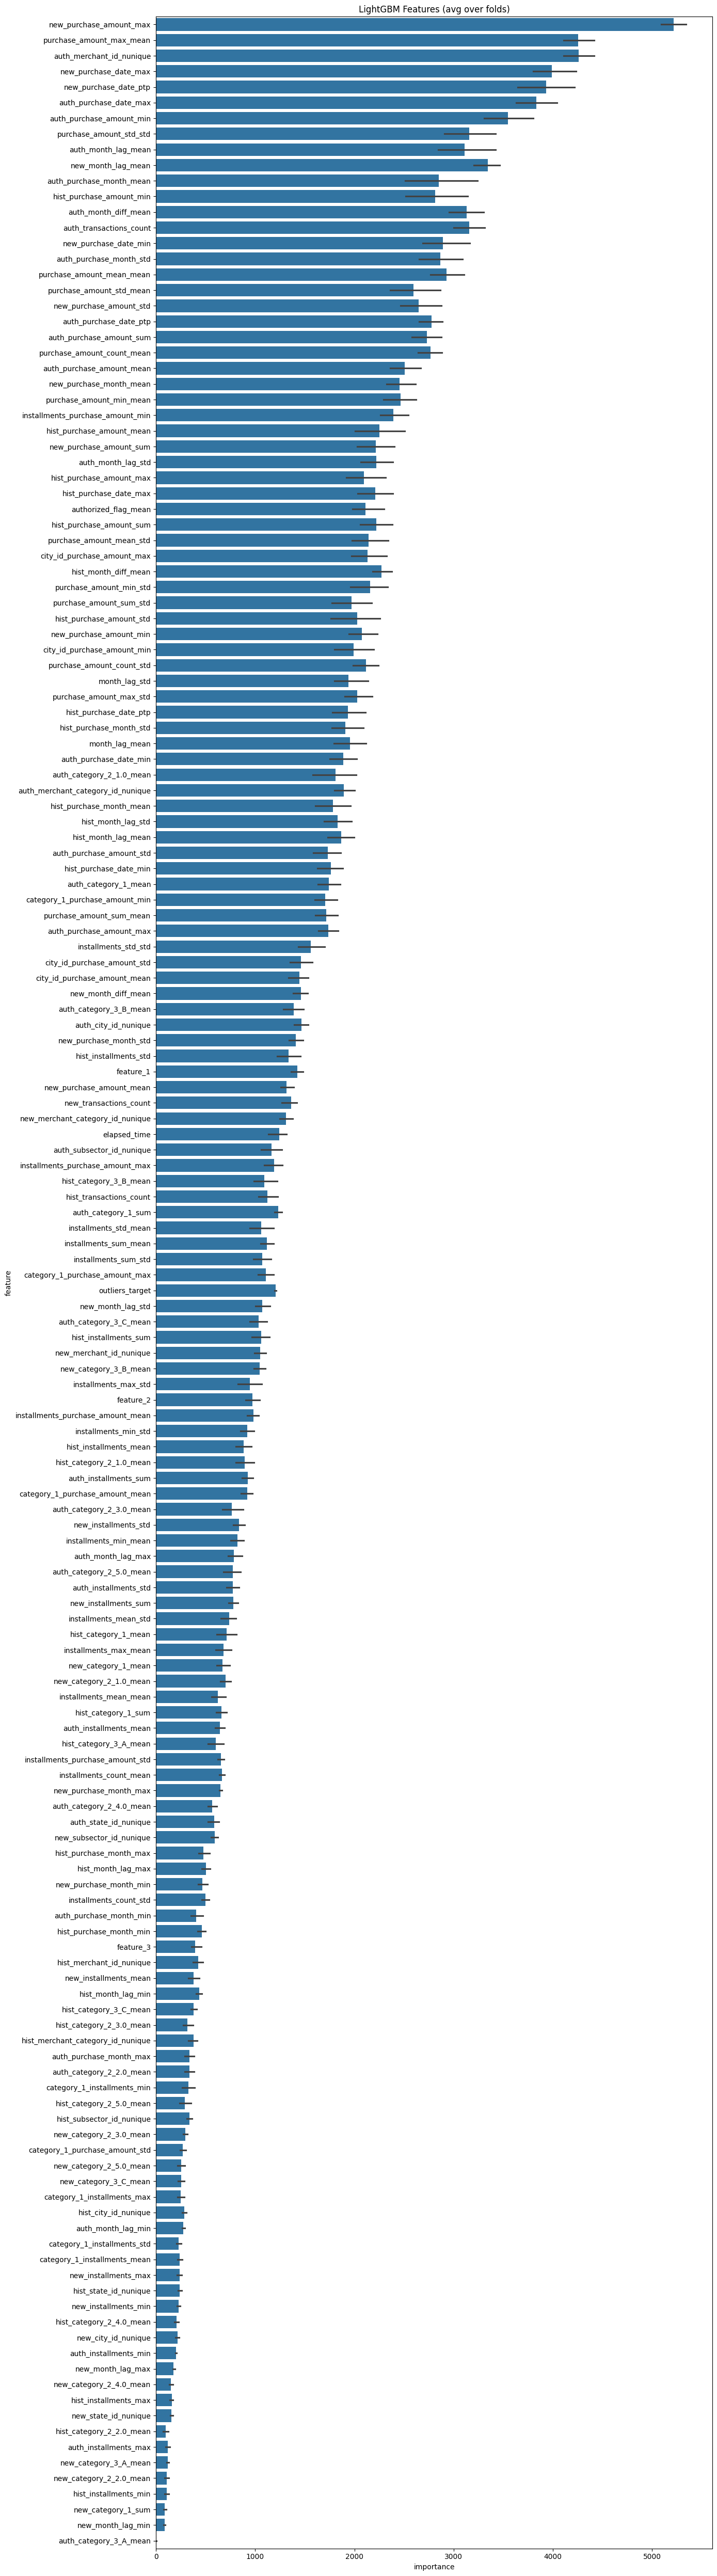

In [27]:
# 特徴量重要度の可視化
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

## 提出ファイルの作成

In [28]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)